In [32]:
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("netflix_titles.csv")
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


## Data Cleaning
Checking the Missing Value and dealing with it

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Lets check how many nulls are there in the data

In [35]:
df.nunique()

show_id         8807
type               2
title           8807
director        4528
cast            7692
country          748
date_added      1767
release_year      74
rating            17
duration         220
listed_in        514
description     8775
dtype: int64

In [36]:
df.isna().sum()

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

The missing values are in:

* <code>director</code>: i think its not needed for the analysis (no much information)
* <code>cast</code>: this var has too many diferent values too so there is no muich information out there
* <code>country</code>: this is a importante variable so we will think how to fix it (maybe mode)
* <code>date_added</code>: there are just a few cases, so lets scrap them
* <code>rating</code>: there are just a few cases, so lets scrap them

### Drop director and cast columns

Director and cast column would not help in Analysis so you can drop them

In [37]:
df = df.drop(['director', 'cast', 'show_id'], axis=1)
df.columns

Index(['type', 'title', 'country', 'date_added', 'release_year', 'rating',
       'duration', 'listed_in', 'description'],
      dtype='object')

### Fixing Rating values


In [38]:
df['rating'].unique()


array(['PG-13', 'TV-MA', 'PG', 'TV-14', 'TV-PG', 'TV-Y', 'TV-Y7', 'R',
       'TV-G', 'G', 'NC-17', '74 min', '84 min', '66 min', 'NR', nan,
       'TV-Y7-FV', 'UR'], dtype=object)

In [39]:
df[df['rating'].isna()]

,type,title,country,date_added,release_year,rating,duration,listed_in,description
5989,Movie,13TH: A Conversation with Oprah Winfrey & Ava ...,NaN,"January 26, 2017",2017,NaN,37 min,Movies,Oprah Winfrey sits down with director Ava DuVe...
6827,TV Show,Gargantia on the Verdurous Planet,Japan,"December 1, 2016",2013,NaN,1 Season,"Anime Series, International TV Shows","After falling through a wormhole, a space-dwel..."
7312,TV Show,Little Lunch,Australia,"February 1, 2018",2015,NaN,1 Season,"Kids' TV, TV Comedies","Adopting a child's perspective, this show take..."
7537,Movie,My Honor Was Loyalty,Italy,"March 1, 2017",2015,NaN,115 min,Dramas,"Amid the chaos and horror of World War II, a c..."


In [40]:
df = df.dropna(subset=['rating', 'duration', 'date_added'])

In [41]:
df[df['rating'].isin(['74 min', '84 min', '66 min'])]

,type,title,country,date_added,release_year,rating,duration,listed_in,description


Seems like values of duration is in Rating column. Since we are going to remove this column eventaully as rating would be null.

In [42]:
df = df[~df['rating'].isin(['74 min', '84 min', '66 min'])]

Now Country and Data_added turn

In [43]:
df[df['date_added'].isna()]

,type,title,country,date_added,release_year,rating,duration,listed_in,description


As there are only 10 columns, these can be dropped

In [44]:
df = df[df['date_added'].notna()]

Fixing country missing values

In [45]:
df.isna().sum()

type              0
title             0
country         829
date_added        0
release_year      0
rating            0
duration          0
listed_in         0
description       0
dtype: int64

Check if data is cleaned

### Adding more columns for EDA

Year and month can be extracted from the data_added, it can helpful in some comparision later

In [46]:
df['year_added'] = df['date_added'].apply(lambda x: x.split(" ")[-1])
df['year_added'].head()

0    2021
1    2021
2    2021
3    2021
4    2021
Name: year_added, dtype: object

In [47]:
df['month_added'] = df['date_added'].apply(lambda x: x.split(" ")[0])
df['month_added'].head()

0    September
1    September
2    September
3    September
4    September
Name: month_added, dtype: object

Adding Targets based on rating¶

In [48]:
map_ratings_and_ages = {
    'TV-PG': '7+',
    'TV-MA': '18+',
    'TV-Y7-FV': '7+',
    'TV-Y7': '7+',
    'TV-14': '16+',
    'R': '18+',
    'TV-Y': 'All',
    'NR': '18+',
    'PG-13': '13+',
    'TV-G': 'All',
    'PG': '7+',
    'G': 'All',
    'UR': '18+',
    'NC-17': '18+'
}

In [49]:
df['target_ages'] = df['rating'].replace(map_ratings_and_ages)
df['target_ages'].unique()

array(['13+', '18+', '7+', '16+', 'All'], dtype=object)

In [50]:
df['country'].unique()

array(['United States', 'South Africa', nan, 'India',
       'United States, Ghana, Burkina Faso, United Kingdom, Germany, Ethiopia',
       'United Kingdom', 'Germany, Czech Republic', 'Mexico', 'Turkey',
       'Australia', 'United States, India, France', 'Finland',
       'China, Canada, United States',
       'South Africa, United States, Japan', 'Nigeria', 'Japan',
       'Spain, United States', 'France', 'Belgium',
       'United Kingdom, United States', 'United States, United Kingdom',
       'France, United States', 'South Korea', 'Spain',
       'United States, Singapore', 'United Kingdom, Australia, France',
       'United Kingdom, Australia, France, United States',
       'United States, Canada', 'Germany, United States',
       'South Africa, United States', 'United States, Mexico',
       'United States, Italy, France, Japan',
       'United States, Italy, Romania, United Kingdom',
       'Australia, United States', 'Argentina, Venezuela',
       'United States, United Kin

As there are multiple countries, I will add new column initial_country which is just first country from the list then drop the country column and rename the new column to country.

In [51]:
df.dtypes

type            object
title           object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
year_added      object
month_added     object
target_ages     object
dtype: object

In [52]:
df['type'] = pd.Categorical(df['type'])

df['target_ages'] = pd.Categorical(df['target_ages'], categories=['All', '7+', '13+', '16+', '+18'])

df['year_added'] = pd.to_numeric(df['year_added'])

Fixing data types

In [53]:
df.dtypes

type            category
title             object
country           object
date_added        object
release_year       int64
rating            object
duration          object
listed_in         object
description       object
year_added         int64
month_added       object
target_ages     category
dtype: object

* type should be a category
* target_ages is also another category
* year_added should be integer for comparision with 'released_year'

In [54]:
df.head()

,type,title,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,target_ages
0,Movie,Dick Johnson Is Dead,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",2021,September,13+
1,TV Show,Blood & Water,South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",2021,September,NaN
2,TV Show,Ganglands,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,2021,September,NaN
3,TV Show,Jailbirds New Orleans,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",2021,September,NaN
4,TV Show,Kota Factory,India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,2021,September,NaN


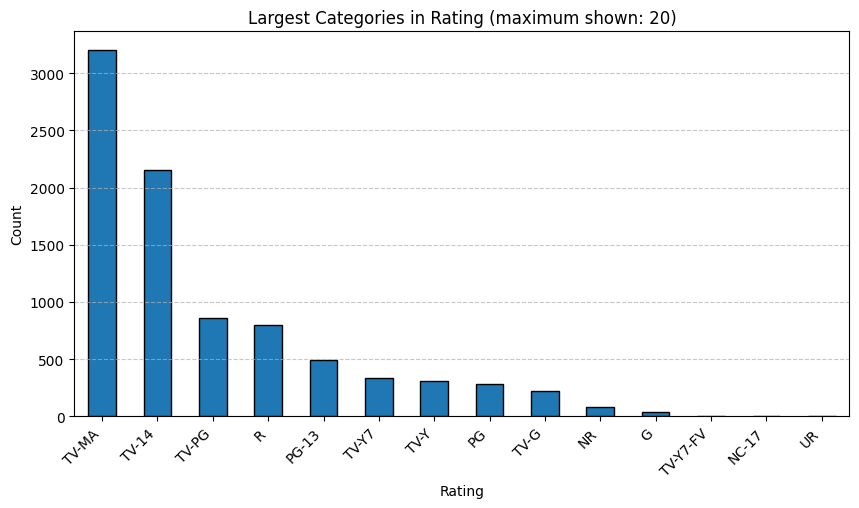

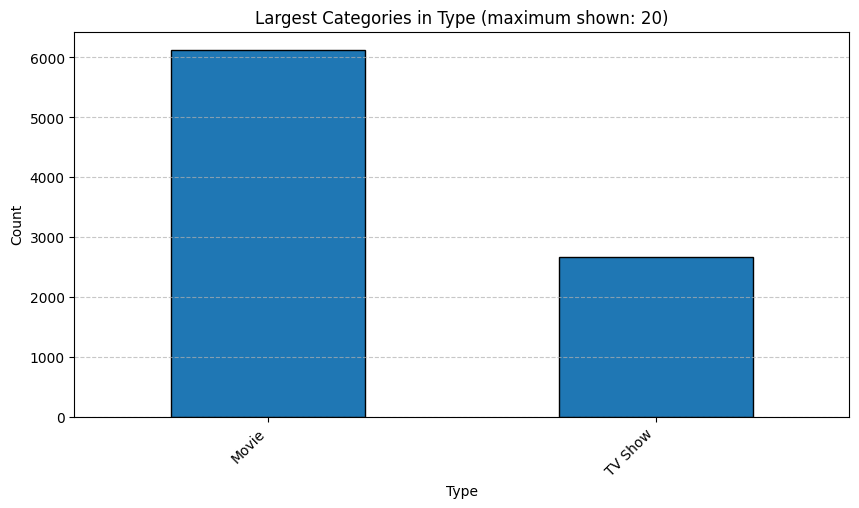

In [55]:
selected_categorical_cols = ['rating', 'type']

# Set a limit for top categories
top_n = 20

# Create bar plots for each selected categorical column
for col in selected_categorical_cols:
    plt.figure(figsize=(10, 5))
    df[col].value_counts().nlargest(top_n).plot(kind='bar', edgecolor='black')
    plt.title(f'Largest Categories in {col.capitalize()} (maximum shown: {top_n})')
    plt.xlabel(col.capitalize())
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_28040\2767266513.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['type'], ax=axes[0, 0], palette="pastel")
C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_28040\2767266513.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_ratings.index, y=top_ratings.values, ax=axes[0, 1], palette="coolwarm")
C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_28040\2767266513.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.index, y=top_countries.values, ax

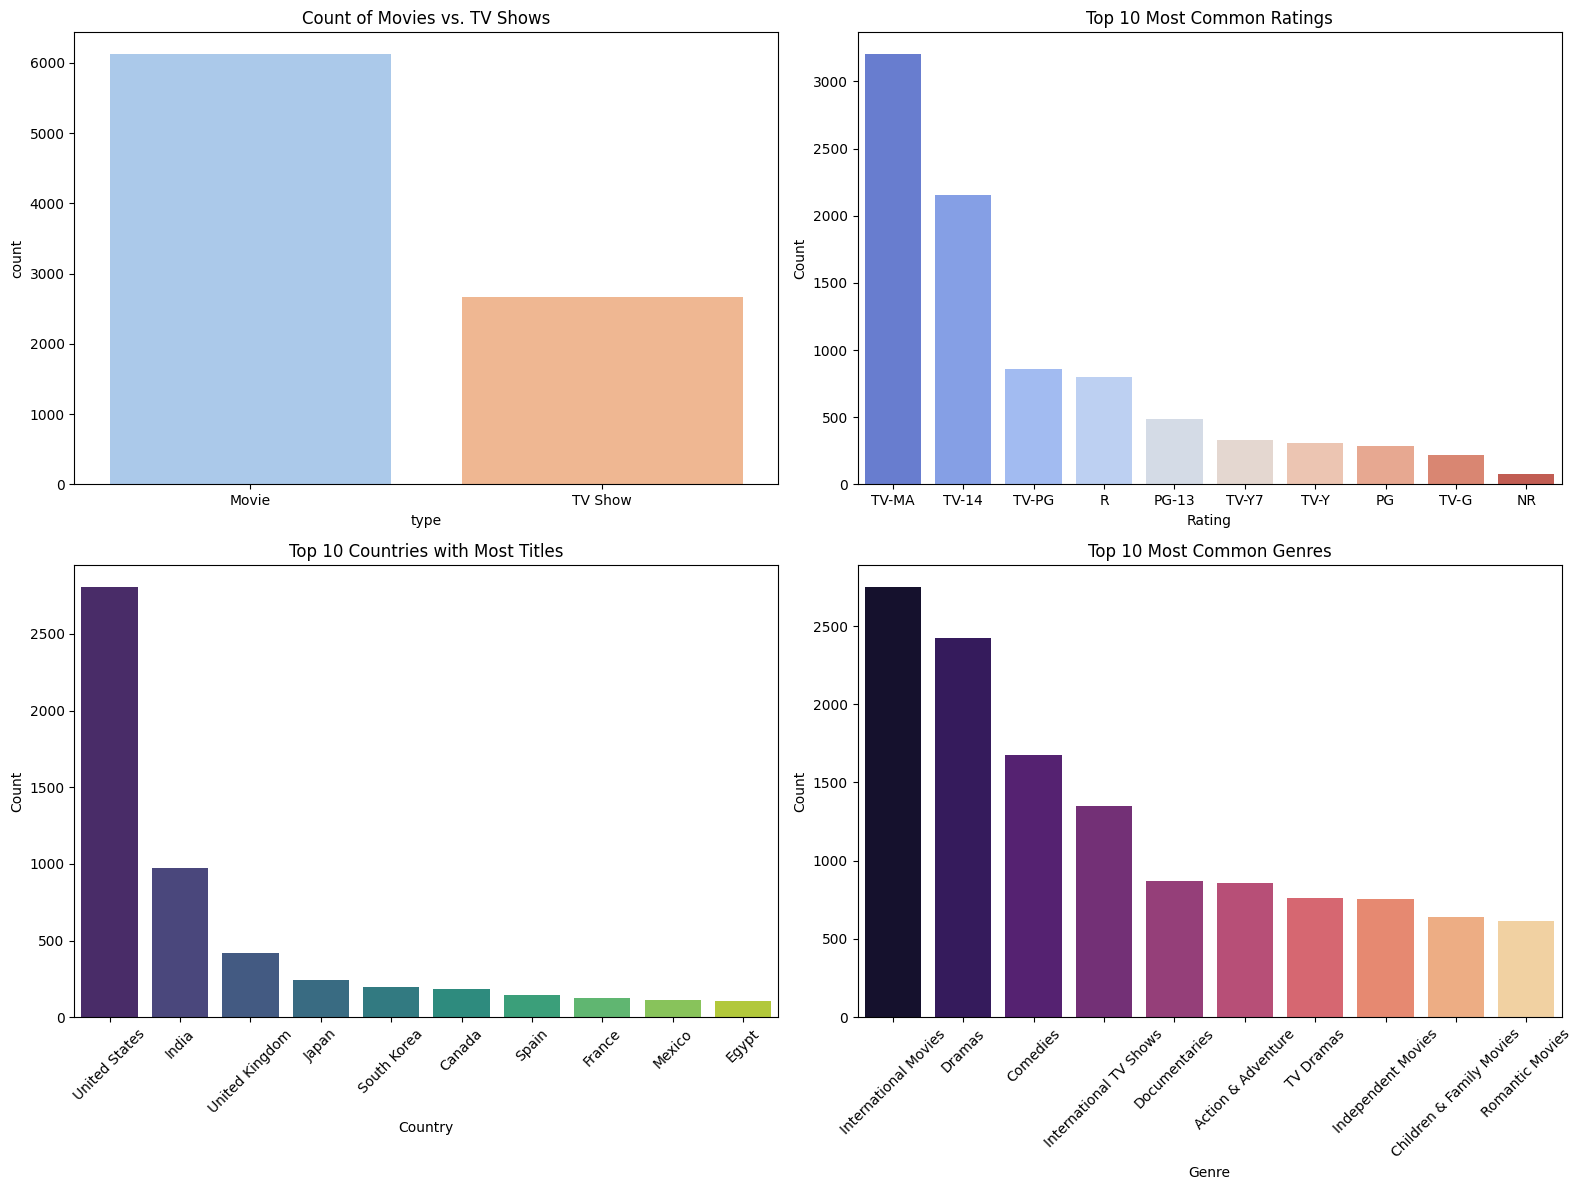

In [56]:
# Set up figure
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Count of Type (Movie vs. TV Show)
sns.countplot(x=df['type'], ax=axes[0, 0], palette="pastel")
axes[0, 0].set_title("Count of Movies vs. TV Shows")

# Plot 2: Top 10 Ratings
top_ratings = df['rating'].value_counts().nlargest(10)
sns.barplot(x=top_ratings.index, y=top_ratings.values, ax=axes[0, 1], palette="coolwarm")
axes[0, 1].set_title("Top 10 Most Common Ratings")
axes[0, 1].set_xlabel("Rating")
axes[0, 1].set_ylabel("Count")

# Plot 3: Top 10 Countries with Most Titles
top_countries = df['country'].value_counts().nlargest(10)
sns.barplot(x=top_countries.index, y=top_countries.values, ax=axes[1, 0], palette="viridis")
axes[1, 0].set_title("Top 10 Countries with Most Titles")
axes[1, 0].set_xlabel("Country")
axes[1, 0].set_ylabel("Count")
axes[1, 0].tick_params(axis='x', rotation=45)

# Plot 4: Top 10 Most Common Genres (Listed In column)
from collections import Counter

# Split and count occurrences of genres
genre_list = df['listed_in'].str.split(', ').explode()
top_genres = pd.Series(Counter(genre_list)).nlargest(10)
sns.barplot(x=top_genres.index, y=top_genres.values, ax=axes[1, 1], palette="magma")
axes[1, 1].set_title("Top 10 Most Common Genres")
axes[1, 1].set_xlabel("Genre")
axes[1, 1].set_ylabel("Count")
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_28040\689323761.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=proportions.index, y=proportions.values, palette='crest')


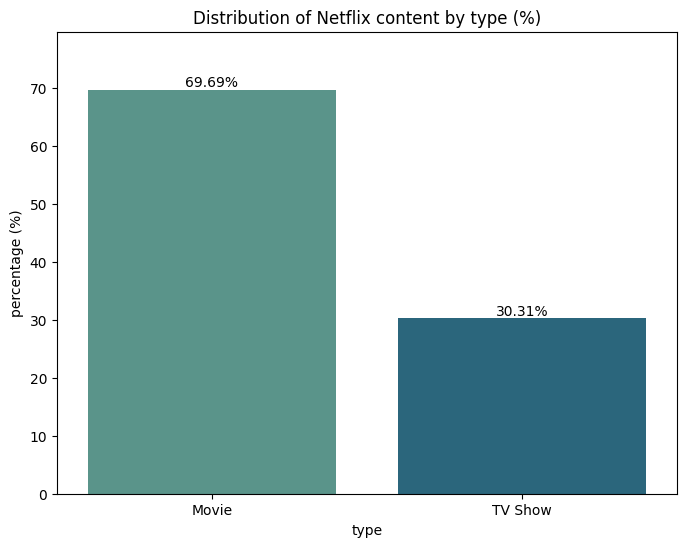

In [57]:
# General function for visualizing percentage frequencies
def plot_category_proportions(df, column, title=None):
    proportions = df[column].value_counts(normalize=True) * 100

    plt.figure(figsize=(8, 6))
    sns.barplot(x=proportions.index, y=proportions.values, palette='crest')
    plt.ylabel('percentage (%)')
    plt.xlabel(column)
    plt.title(title or f'Percentage distribution of {column}')
    plt.ylim(0, proportions.max() + 10)  # Scale Y-axis
    for index, value in enumerate(proportions):
        plt.text(index, value + 0.5, f'{value:.2f}%', ha='center')
    plt.show()

# Application using the example "type"
plot_category_proportions(df=df, column='type', title='Distribution of Netflix content by type (%)')

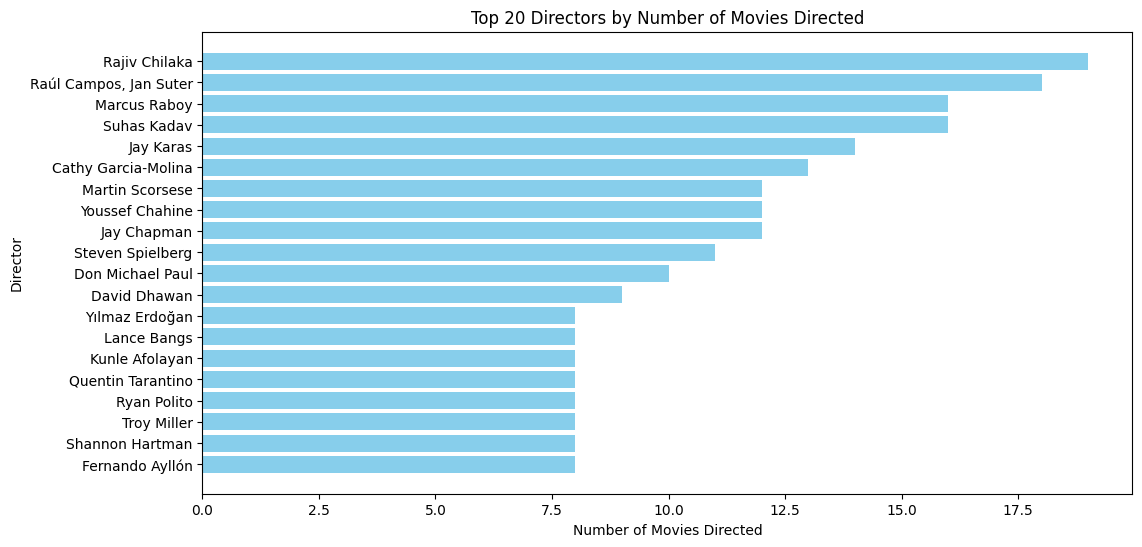

In [58]:
df_director = pd.read_csv("./netflix_titles.csv")
director_movie_counts = df_director["director"].value_counts()
director_movie_counts_df = director_movie_counts.reset_index()
director_movie_counts_df.columns = ["director", "Number of Movies"]
top_directors_df = director_movie_counts_df.head(20)
plt.figure(figsize=(12, 6))
plt.barh(top_directors_df["director"], top_directors_df["Number of Movies"], color='skyblue')
plt.xlabel("Number of Movies Directed")
plt.ylabel("Director")
plt.title("Top 20 Directors by Number of Movies Directed")
plt.gca().invert_yaxis()  # Invert y-axis to show the highest at the top
plt.show()

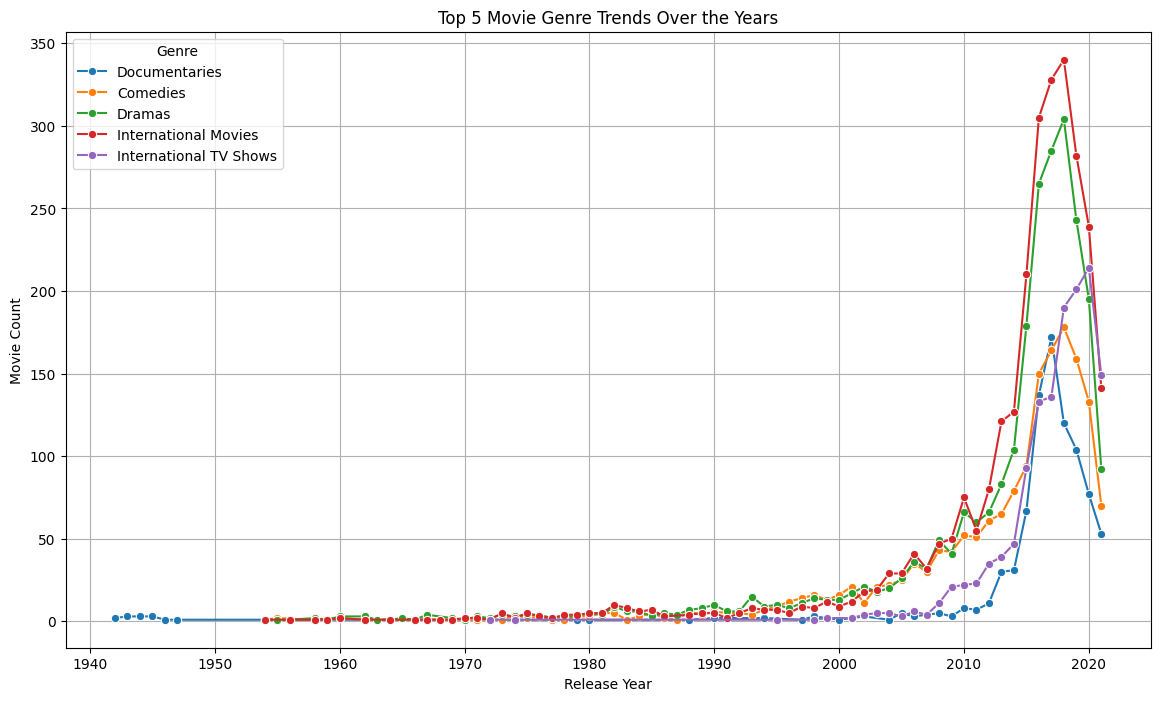

In [59]:

# Ensure 'listed_in' is properly formatted
df.loc[:, 'listed_in'] = df['listed_in'].apply(lambda x: [genre.strip() for genre in x.split(',')] if isinstance(x, str) else x)

# Step 2: Create a list of dictionaries with year and genre pairs
genre_year_data = []
for index, row in df.iterrows():
    if isinstance(row['listed_in'], list):  # Check if genre is a list
        for genre in row['listed_in']:
            genre_year_data.append({'release_year': row['release_year'], 'genre': genre})

# Step 3: Convert to DataFrame and count occurrences
genre_year_df = pd.DataFrame(genre_year_data)
genre_year_counts = genre_year_df.groupby(['release_year', 'genre']).size().reset_index(name='Movie Count')

# Step 4: Get the top 5 genres by total movie count
top_genres = genre_year_counts.groupby('genre')['Movie Count'].sum().sort_values(ascending=False).head(5).index
filtered_genre_year_counts = genre_year_counts[genre_year_counts['genre'].isin(top_genres)]

# Step 5: Plot the trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=filtered_genre_year_counts, x='release_year', y='Movie Count', hue='genre', marker='o')
plt.title('Top 5 Movie Genre Trends Over the Years')
plt.xlabel('Release Year')
plt.ylabel('Movie Count')
plt.legend(title='Genre')
plt.grid(True)
plt.show()

In [60]:
df['type'].value_counts()

type
Movie      6126
TV Show    2664
Name: count, dtype: int64

CategoricalIndex(['Movie', 'TV Show'], categories=['Movie', 'TV Show'], ordered=False, dtype='category', name='type')


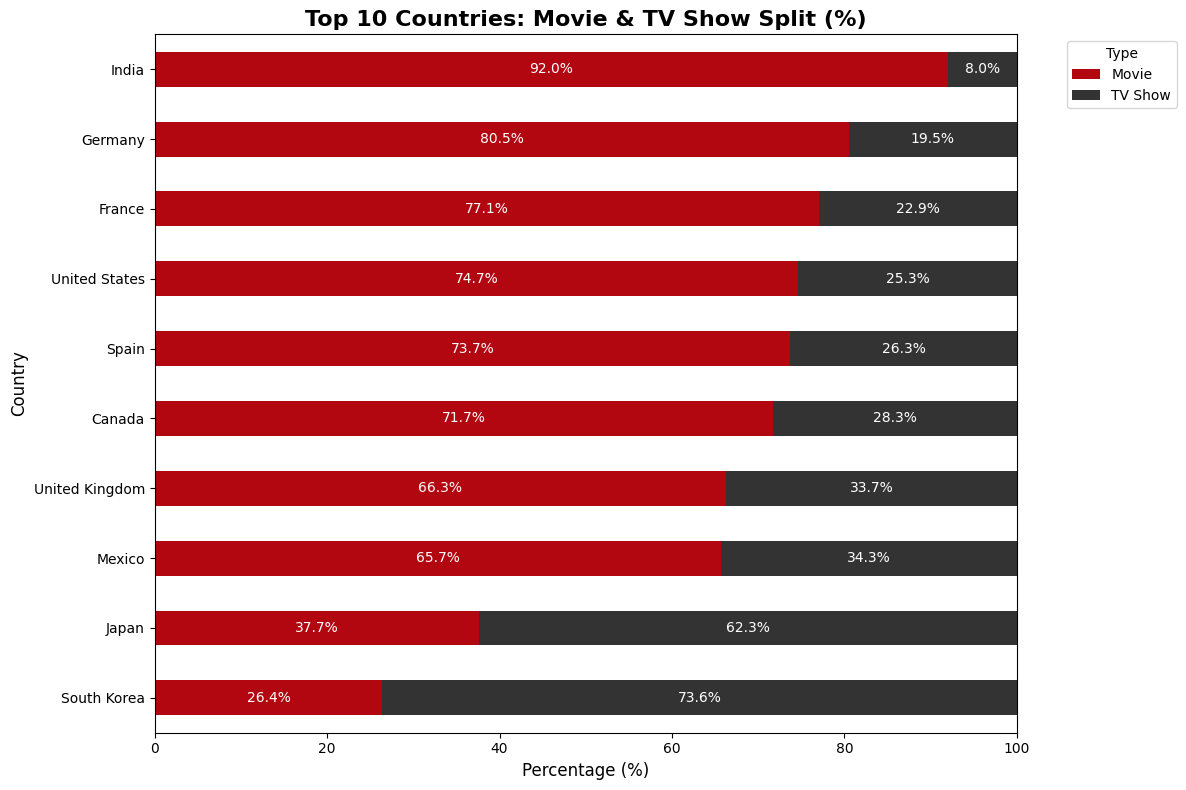

In [61]:
top_n = 10
# df = df.dropna(subset=['country', 'type'])

# Explode multiple countries into separate rows
df_expanded = df.assign(country=df['country'].str.split(', ')).explode('country')

# Top 10 countries by total content count
top_countries = df_expanded['country'].value_counts().head(top_n).index
df_top_countries = df_expanded[df_expanded['country'].isin(top_countries)]

# Crosstabulation: percentage Movies vs. TV Shows per country
country_type = pd.crosstab(df_top_countries['country'], df_top_countries['type'], normalize='index') * 100

# Sort countries by percentage of movies
country_type_sorted = country_type.sort_values(by='Movie', ascending=True)

# Plotting
country_type_sorted.plot(kind='barh', stacked=True, figsize=(12,8), color=['#B20710', '#333333'])

# Customizing the plot
plt.title('Top 10 Countries: Movie & TV Show Split (%)', fontsize=16, weight='bold')
plt.xlabel('Percentage (%)', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, 100)

print(country_type_sorted.columns)


# Adding percentage labels
for idx, row in enumerate(country_type_sorted.itertuples()):
    movie_pct = getattr(row, 'Movie')
    tv_show_pct = getattr(row, '_2')  # Using positional index for 'TV Show' column
    plt.text(movie_pct / 2, idx, f"{movie_pct:.1f}%", ha='center', va='center', color='white', fontsize=10)
    plt.text(movie_pct + tv_show_pct / 2, idx, f"{tv_show_pct:.1f}%", ha='center', va='center', color='white', fontsize=10)

plt.tight_layout()
plt.show()

C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_28040\2853888436.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_yearly = df.groupby(['release_year', 'type']).size().reset_index(name='counts')


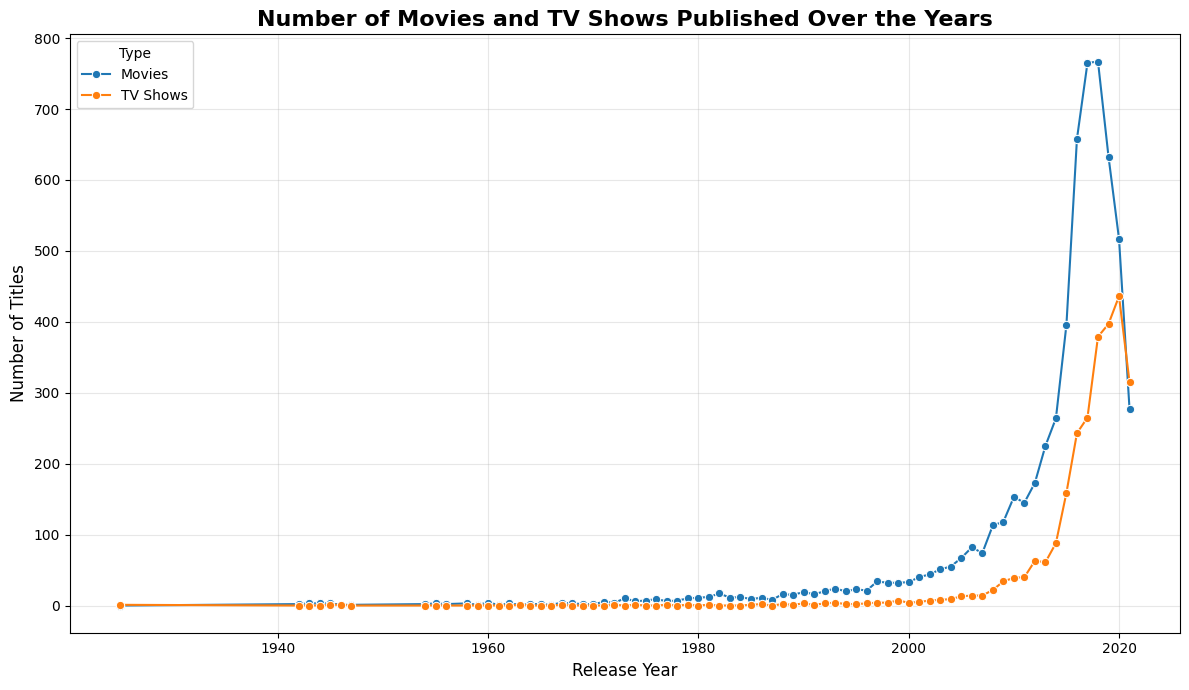

In [62]:
# Prepare data
df_yearly = df.groupby(['release_year', 'type']).size().reset_index(name='counts')

# Pivot the data to get Movies and TV Shows separately
df_pivot = df_yearly.pivot(index='release_year', columns='type', values='counts').fillna(0)

# Plotting two line plots in one graph
plt.figure(figsize=(12, 7))

sns.lineplot(data=df_pivot['Movie'], marker='o', label='Movies')
sns.lineplot(data=df_pivot['TV Show'], marker='o', label='TV Shows')

# Customizing plot
plt.title('Number of Movies and TV Shows Published Over the Years', fontsize=16, weight='bold')
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.legend(title='Type')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

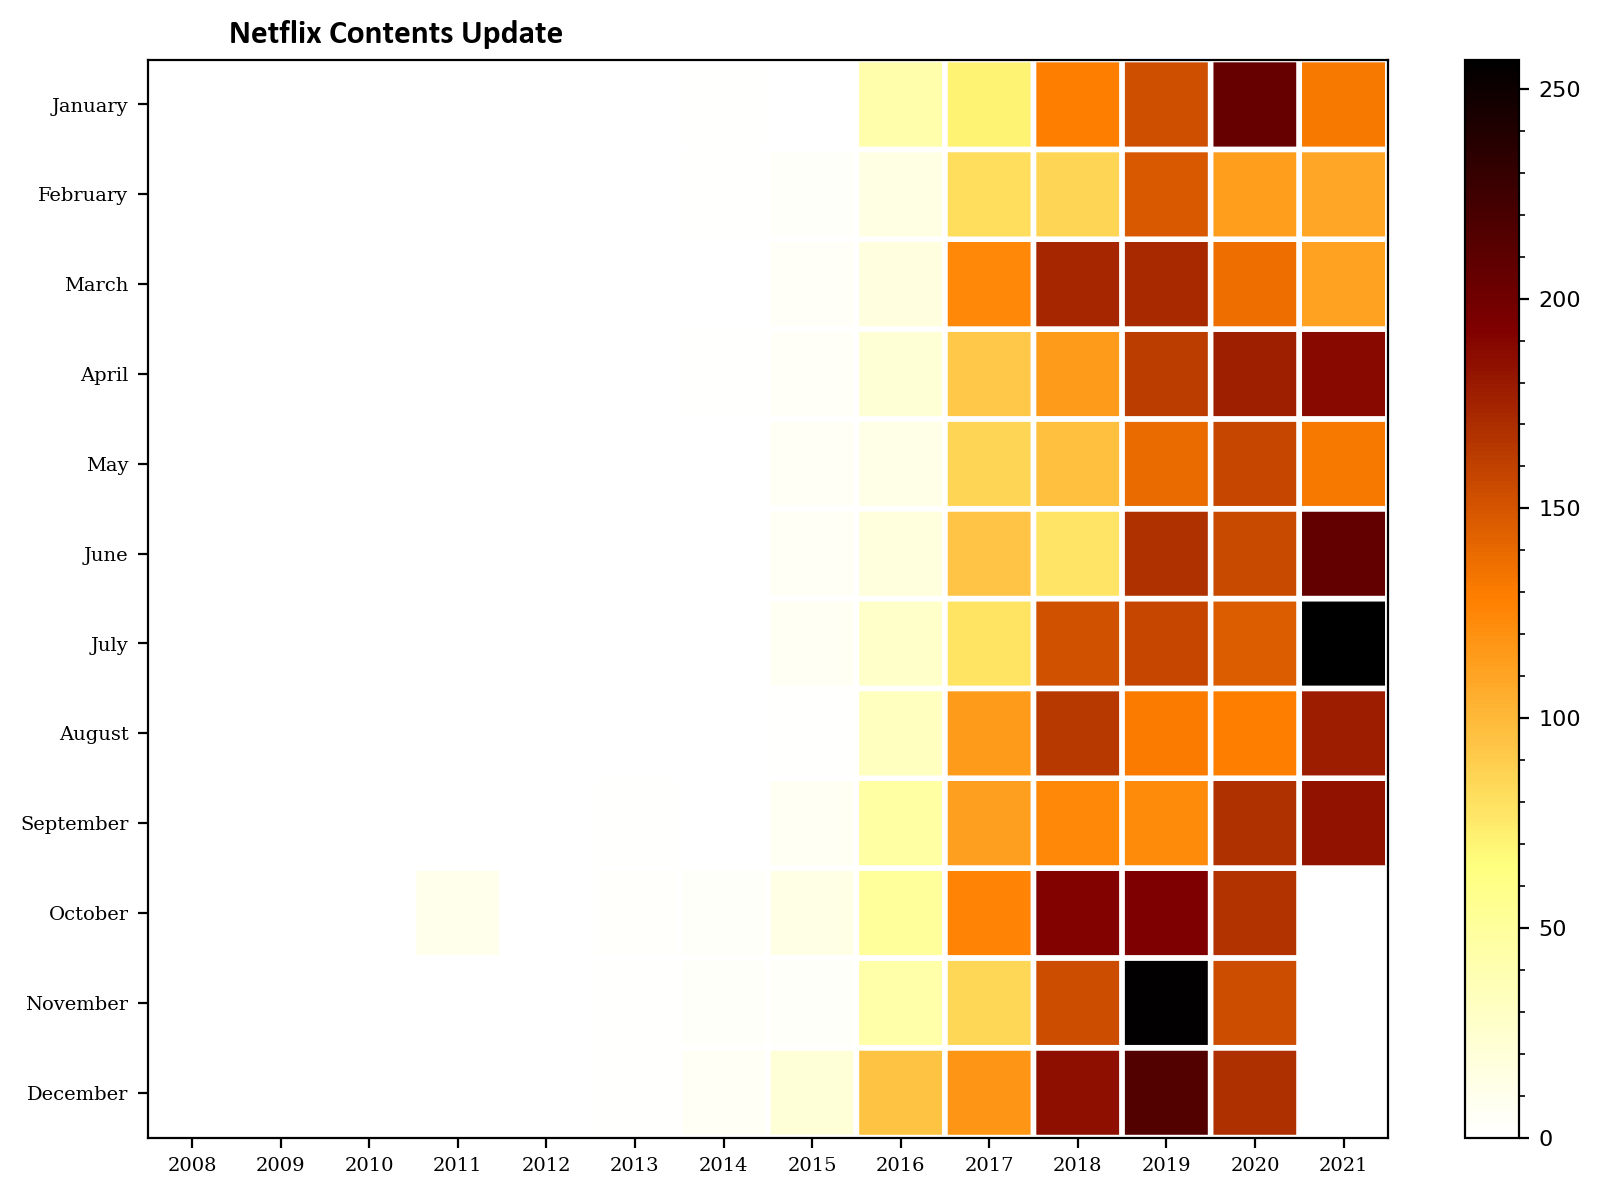

In [63]:
netflix_date = df[['date_added']].dropna()
netflix_date['year'] = netflix_date['date_added'].apply(lambda x : x.split(', ')[-1])
netflix_date['month'] = netflix_date['date_added'].apply(lambda x : x.lstrip().split(' ')[0])

month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'][::-1]
df_data_netflix = netflix_date.groupby('year')['month'].value_counts().unstack().fillna(0)[month_order].T
plt.figure(figsize=(10, 7), dpi=200)
plt.pcolor(df_data_netflix, cmap='afmhot_r', edgecolors='white', linewidths=2) # heatmap
plt.xticks(np.arange(0.5, len(df_data_netflix.columns), 1), df_data_netflix.columns, fontsize=7, fontfamily='serif')
plt.yticks(np.arange(0.5, len(df_data_netflix.index), 1), df_data_netflix.index, fontsize=7, fontfamily='serif')

plt.title('Netflix Contents Update', fontsize=12, fontfamily='calibri', fontweight='bold', position=(0.20, 1.0+0.02))
cbar = plt.colorbar()

cbar.ax.tick_params(labelsize=8)
cbar.ax.minorticks_on()
plt.show()

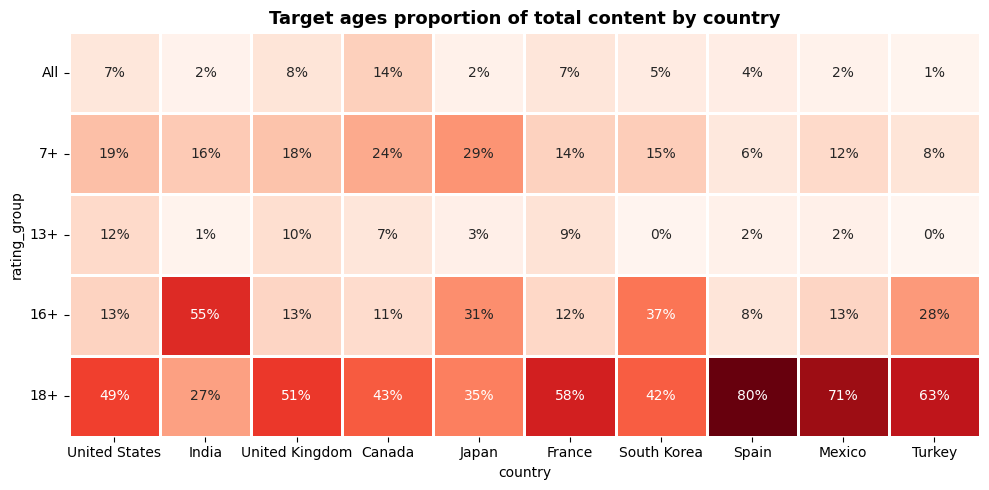

In [64]:
# 1) Select 'country' and 'rating', drop rows missing either
df_dataset = df[['country', 'rating']].dropna(subset=['country', 'rating']).copy()

# 2) Split multiple countries into separate rows
df_dataset['country'] = df_dataset['country'].str.split(', ')
df_dataset = df_dataset.explode('country')  # each country gets its own row

# 3) Map each rating to your custom categories
df_dataset['rating_group'] = df_dataset['rating'].map(map_ratings_and_ages)

# Drop rows that didn't map (NaN)
df_dataset = df_dataset.dropna(subset=['rating_group'])

# 4) Pick the countries you want to focus on
top_countries = ["United States", "India", "United Kingdom", "Canada", "Japan",
                 "France", "South Korea", "Spain", "Mexico", "Turkey"]
df_dataset = df_dataset[df_dataset['country'].isin(top_countries)]

# 5) Count how many titles each (country, rating_group) has
counts = df_dataset.groupby(['country','rating_group']).size().unstack(fill_value=0)

# 6) Convert counts to row-wise proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# 7) Reindex columns to your desired rating order
desired_order = ['All', '7+', '13+', '16+', '18+']
proportions = proportions.reindex(columns=desired_order, fill_value=0)

# Reindex rows to keep the country order you defined
proportions = proportions.reindex(index=top_countries)

# 8) Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(
    proportions.T,        # Transpose so rating categories are rows
    cmap="Reds",
    annot=True,
    fmt=".0%",            # Format cells as percentages
    cbar=False,           # Hide colorbar (optional)
    linewidths=2,
    linecolor='white'
)

plt.title("Target ages proportion of total content by country",
          fontsize=13, fontweight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

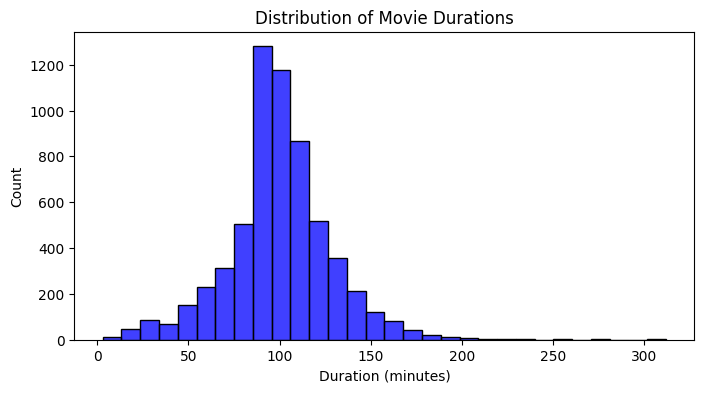

In [65]:

# Ensure all values are strings before using .str.replace()
duration_var = df['duration'].astype(str).str.replace(' min', '', regex=False)

# Convert to numeric, coercing errors to NaN
duration_var = pd.to_numeric(duration_var, errors='coerce')

# Plot the histogram
plt.figure(figsize=(8, 4))
sns.histplot(duration_var.dropna(), bins=30, kde=False, color='blue')
plt.title("Distribution of Movie Durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Count")
plt.show()

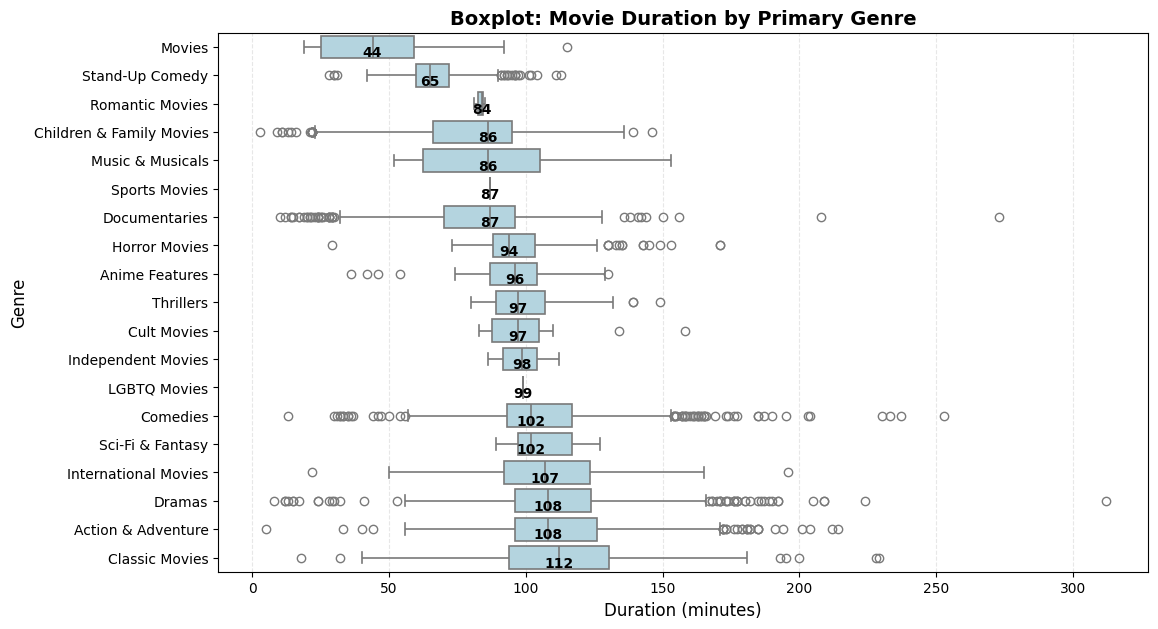

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Remove NaN durations and keep only 'Movie' type
movie_durations = df[df['type'] == 'Movie'].dropna(subset=['duration'])

# Convert 'duration' column to numeric
movie_durations['duration'] = movie_durations['duration'].astype(str).str.replace(' min', '', regex=False)
movie_durations['duration'] = pd.to_numeric(movie_durations['duration'], errors='coerce')

# Extract primary genre, handling lists and strings properly
movie_durations['primary_genre'] = movie_durations['listed_in'].apply(
    lambda x: x[0] if isinstance(x, list) else str(x).split(',')[0] if pd.notna(x) else x
)

# Sort genres by median duration for better readability
genre_order = movie_durations.groupby('primary_genre')['duration'].median().sort_values().index

# Set figure size
plt.figure(figsize=(12, 7))

# Create boxplot with improved colors and contrast
ax = sns.boxplot(
    x=movie_durations['duration'],
    y=movie_durations['primary_genre'],
    order=genre_order,
    color="lightblue",
    linewidth=1.2
)

# Add median value labels on each box
medians = movie_durations.groupby('primary_genre')['duration'].median()
for i, genre in enumerate(genre_order):
    median_val = medians[genre]
    plt.text(median_val, i + 0.2, f"{median_val:.0f}", ha="center", va="center",
             fontsize=10, color="black", fontweight="bold")

# Titles and labels
plt.title("Boxplot: Movie Duration by Primary Genre", fontsize=14, fontweight="bold")
plt.xlabel("Duration (minutes)", fontsize=12)
plt.ylabel("Genre", fontsize=12)

# Adjust grid transparency for a cleaner look
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Show the plot
plt.show()


Kolmogorov-Smirnov Test results: KS-statistic=0.8118876551273677, p-value=0.0709221718070185


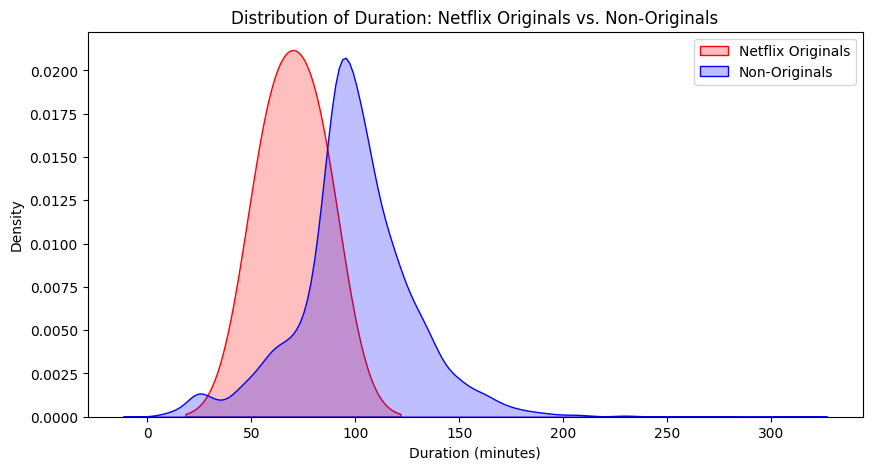

In [67]:
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'duration' is numeric by removing ' min' and converting to integer
df['duration'] = df['duration'].astype(str).str.replace(' min', '', regex=False)
df['duration'] = pd.to_numeric(df['duration'], errors='coerce')

# Filter Netflix Originals and Non-Originals
netflix_originals = df[df['title'].str.contains("Netflix", na=False)]['duration'].dropna()
non_originals = df[~df['title'].str.contains("Netflix", na=False)]['duration'].dropna()

# Perform Kolmogorov-Smirnov test
ks_stat, ks_p_value = stats.ks_2samp(netflix_originals, non_originals)
print(f"Kolmogorov-Smirnov Test results: KS-statistic={ks_stat}, p-value={ks_p_value}")

# Plot KDE
plt.figure(figsize=(10, 5))
sns.kdeplot(netflix_originals, label='Netflix Originals', fill=True, color='red')
sns.kdeplot(non_originals, label='Non-Originals', fill=True, color='blue')

# Titles and labels
plt.title("Distribution of Duration: Netflix Originals vs. Non-Originals")
plt.xlabel("Duration (minutes)")
plt.ylabel("Density")
plt.legend()
plt.show()


In [68]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import pandas as pd

country_codes = {'afghanistan': 'AFG',
 'albania': 'ALB',
 'algeria': 'DZA',
 'american samoa': 'ASM',
 'andorra': 'AND',
 'angola': 'AGO',
 'anguilla': 'AIA',
 'antigua and barbuda': 'ATG',
 'argentina': 'ARG',
 'armenia': 'ARM',
 'aruba': 'ABW',
 'australia': 'AUS',
 'austria': 'AUT',
 'azerbaijan': 'AZE',
 'bahamas': 'BHM',
 'bahrain': 'BHR',
 'bangladesh': 'BGD',
 'barbados': 'BRB',
 'belarus': 'BLR',
 'belgium': 'BEL',
 'belize': 'BLZ',
 'benin': 'BEN',
 'bermuda': 'BMU',
 'bhutan': 'BTN',
 'bolivia': 'BOL',
 'bosnia and herzegovina': 'BIH',
 'botswana': 'BWA',
 'brazil': 'BRA',
 'british virgin islands': 'VGB',
 'brunei': 'BRN',
 'bulgaria': 'BGR',
 'burkina faso': 'BFA',
 'burma': 'MMR',
 'burundi': 'BDI',
 'cabo verde': 'CPV',
 'cambodia': 'KHM',
 'cameroon': 'CMR',
 'canada': 'CAN',
 'cayman islands': 'CYM',
 'central african republic': 'CAF',
 'chad': 'TCD',
 'chile': 'CHL',
 'china': 'CHN',
 'colombia': 'COL',
 'comoros': 'COM',
 'congo democratic': 'COD',
 'Congo republic': 'COG',
 'cook islands': 'COK',
 'costa rica': 'CRI',
 "cote d'ivoire": 'CIV',
 'croatia': 'HRV',
 'cuba': 'CUB',
 'curacao': 'CUW',
 'cyprus': 'CYP',
 'czech republic': 'CZE',
 'denmark': 'DNK',
 'djibouti': 'DJI',
 'dominica': 'DMA',
 'dominican republic': 'DOM',
 'ecuador': 'ECU',
 'egypt': 'EGY',
 'el salvador': 'SLV',
 'equatorial guinea': 'GNQ',
 'eritrea': 'ERI',
 'estonia': 'EST',
 'ethiopia': 'ETH',
 'falkland islands': 'FLK',
 'faroe islands': 'FRO',
 'fiji': 'FJI',
 'finland': 'FIN',
 'france': 'FRA',
 'french polynesia': 'PYF',
 'gabon': 'GAB',
 'gambia, the': 'GMB',
 'georgia': 'GEO',
 'germany': 'DEU',
 'ghana': 'GHA',
 'gibraltar': 'GIB',
 'greece': 'GRC',
 'greenland': 'GRL',
 'grenada': 'GRD',
 'guam': 'GUM',
 'guatemala': 'GTM',
 'guernsey': 'GGY',
 'guinea-bissau': 'GNB',
 'guinea': 'GIN',
 'guyana': 'GUY',
 'haiti': 'HTI',
 'honduras': 'HND',
 'hong kong': 'HKG',
 'hungary': 'HUN',
 'iceland': 'ISL',
 'india': 'IND',
 'indonesia': 'IDN',
 'iran': 'IRN',
 'iraq': 'IRQ',
 'ireland': 'IRL',
 'isle of man': 'IMN',
 'israel': 'ISR',
 'italy': 'ITA',
 'jamaica': 'JAM',
 'japan': 'JPN',
 'jersey': 'JEY',
 'jordan': 'JOR',
 'kazakhstan': 'KAZ',
 'kenya': 'KEN',
 'kiribati': 'KIR',
 'north korea': 'PRK',
 'south korea': 'KOR',
 'kosovo': 'KSV',
 'kuwait': 'KWT',
 'kyrgyzstan': 'KGZ',
 'laos': 'LAO',
 'latvia': 'LVA',
 'lebanon': 'LBN',
 'lesotho': 'LSO',
 'liberia': 'LBR',
 'libya': 'LBY',
 'liechtenstein': 'LIE',
 'lithuania': 'LTU',
 'luxembourg': 'LUX',
 'macau': 'MAC',
 'macedonia': 'MKD',
 'madagascar': 'MDG',
 'malawi': 'MWI',
 'malaysia': 'MYS',
 'maldives': 'MDV',
 'mali': 'MLI',
 'malta': 'MLT',
 'marshall islands': 'MHL',
 'mauritania': 'MRT',
 'mauritius': 'MUS',
 'mexico': 'MEX',
 'micronesia': 'FSM',
 'moldova': 'MDA',
 'monaco': 'MCO',
 'mongolia': 'MNG',
 'montenegro': 'MNE',
 'morocco': 'MAR',
 'mozambique': 'MOZ',
 'namibia': 'NAM',
 'nepal': 'NPL',
 'netherlands': 'NLD',
 'new caledonia': 'NCL',
 'new zealand': 'NZL',
 'nicaragua': 'NIC',
 'nigeria': 'NGA',
 'niger': 'NER',
 'niue': 'NIU',
 'northern mariana islands': 'MNP',
 'norway': 'NOR',
 'oman': 'OMN',
 'pakistan': 'PAK',
 'palau': 'PLW',
 'panama': 'PAN',
 'papua new guinea': 'PNG',
 'paraguay': 'PRY',
 'peru': 'PER',
 'philippines': 'PHL',
 'poland': 'POL',
 'portugal': 'PRT',
 'puerto rico': 'PRI',
 'qatar': 'QAT',
 'romania': 'ROU',
 'russia': 'RUS',
 'rwanda': 'RWA',
 'saint kitts and nevis': 'KNA',
 'saint lucia': 'LCA',
 'saint martin': 'MAF',
 'saint pierre and miquelon': 'SPM',
 'saint vincent and the grenadines': 'VCT',
 'samoa': 'WSM',
 'san marino': 'SMR',
 'sao tome and principe': 'STP',
 'saudi arabia': 'SAU',
 'senegal': 'SEN',
 'serbia': 'SRB',
 'seychelles': 'SYC',
 'sierra leone': 'SLE',
 'singapore': 'SGP',
 'sint maarten': 'SXM',
 'slovakia': 'SVK',
 'slovenia': 'SVN',
 'solomon islands': 'SLB',
 'somalia': 'SOM',
 'south africa': 'ZAF',
 'south sudan': 'SSD',
 'spain': 'ESP',
 'sri lanka': 'LKA',
 'sudan': 'SDN',
 'suriname': 'SUR',
 'swaziland': 'SWZ',
 'sweden': 'SWE',
 'switzerland': 'CHE',
 'syria': 'SYR',
 'taiwan': 'TWN',
 'tajikistan': 'TJK',
 'tanzania': 'TZA',
 'thailand': 'THA',
 'timor-leste': 'TLS',
 'togo': 'TGO',
 'tonga': 'TON',
 'trinidad and tobago': 'TTO',
 'tunisia': 'TUN',
 'turkey': 'TUR',
 'turkmenistan': 'TKM',
 'tuvalu': 'TUV',
 'uganda': 'UGA',
 'ukraine': 'UKR',
 'united arab emirates': 'ARE',
 'united kingdom': 'GBR',
 'united states': 'USA',
 'uruguay': 'URY',
 'uzbekistan': 'UZB',
 'vanuatu': 'VUT',
 'venezuela': 'VEN',
 'vietnam': 'VNM',
 'virgin islands': 'VGB',
 'west bank': 'WBG',
 'yemen': 'YEM',
 'zambia': 'ZMB',
 'zimbabwe': 'ZWE'}

## countries
from collections import Counter
colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]

def geoplot(ddf):
    country_with_code, country = {}, {}
    shows_countries = ", ".join(ddf['country'].dropna()).split(", ")
    for c,v in dict(Counter(shows_countries)).items():
        code = ""
        if c.lower() in country_codes:
            code = country_codes[c.lower()]
        country_with_code[code] = v
        country[c] = v

    data = [dict(
            type = 'choropleth',
            locations = list(country_with_code.keys()),
            z = list(country_with_code.values()),
            colorscale = [[0,"rgb(5, 10, 172)"],[0.65,"rgb(40, 60, 190)"],[0.75,"rgb(70, 100, 245)"],\
                        [0.80,"rgb(90, 120, 245)"],[0.9,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
            autocolorscale = False,
            reversescale = True,
            marker = dict(
                line = dict (
                    color = 'gray',
                    width = 0.5
                ) ),
            colorbar = dict(
                autotick = False,
                title = ''),
          ) ]

    layout = dict(
        title = '',
        geo = dict(
            showframe = False,
            showcoastlines = False,
            projection = dict(
                type = 'Mercator'
            )
        )
    )

    fig = dict( data=data, layout=layout )
    iplot( fig, validate=False, filename='d3-world-map' )
    return country

country_vals = geoplot(df)
tabs = Counter(country_vals).most_common(25)

labels = [_[0] for _ in tabs][::-1]
values = [_[1] for _ in tabs][::-1]
trace1 = go.Bar(y=labels, x=values, orientation="h", name="", marker=dict(color="#a678de"))

data = [trace1]
layout = go.Layout(title="Countries with most content", height=700, legend=dict(x=0.1, y=1.1, orientation="h"))
fig = go.Figure(data, layout=layout)
fig.show()

Final proportions shape: (9, 5)
rating_group          All        7+       13+       16+       18+
listed_in                                                        
'International   0.008403  0.075630  0.310924  0.588235  0.016807
['Dramas'        0.000000  0.072100  0.285266  0.639498  0.003135
['Comedies'      0.000000  0.073593  0.424242  0.493506  0.008658
'International   0.000000  0.086957  0.369565  0.543478  0.000000
['International  0.000000  0.000000  0.000000  1.000000  0.000000


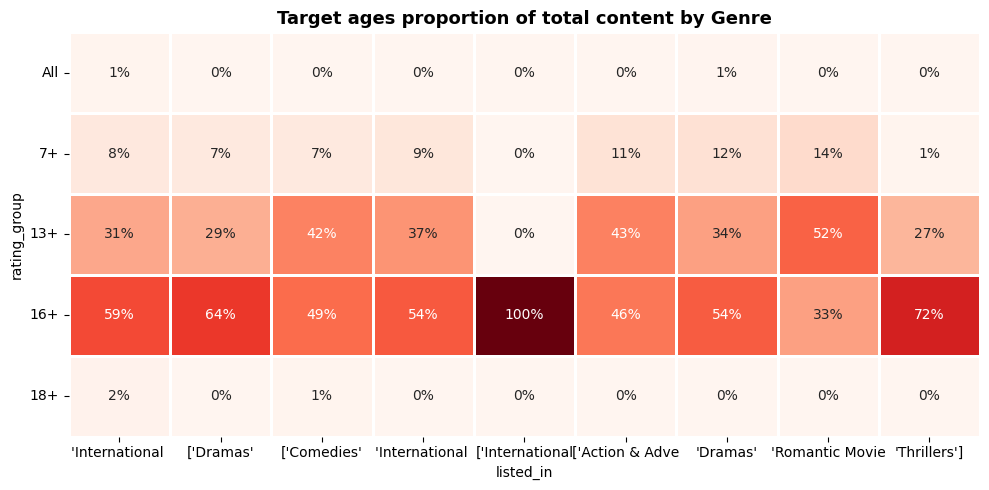

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the rating mapping
map_ratings_and_ages = {
    "G": "All", "PG": "7+", "PG-13": "13+", "R": "16+", "NC-17": "18+"
}

# 1) Select 'listed_in' (Genres) and 'rating', drop rows with NaN
df_dataset = df[['listed_in', 'rating']].dropna(subset=['listed_in', 'rating']).copy()

# 2) Ensure 'listed_in' is a string and explode it properly
df_dataset['listed_in'] = df_dataset['listed_in'].astype(str).apply(lambda x: x.split(', ') if isinstance(x, str) else [])
df_dataset = df_dataset.explode('listed_in')

# 3) Map ratings to custom categories
df_dataset['rating_group'] = df_dataset['rating'].map(map_ratings_and_ages)

# Drop rows with NaN (ratings that didn't map)
df_dataset = df_dataset.dropna(subset=['rating_group'])

# 4) Ensure 'listed_in' is exploded in the original dataframe before counting
df_exploded = df.copy()
df_exploded['listed_in'] = df_exploded['listed_in'].astype(str).apply(lambda x: x.split(', ') if isinstance(x, str) else [])
df_exploded = df_exploded.explode('listed_in')

# Get top 10 most common genres, ensuring only valid ones are selected
top_genres = df_exploded['listed_in'].value_counts().head(10).index.tolist()

# 5) Count how many titles each (genre, rating_group) has
counts = df_dataset.groupby(['listed_in', 'rating_group']).size().unstack(fill_value=0)

# 6) Convert counts to proportions
proportions = counts.div(counts.sum(axis=1), axis=0)

# 7) Ensure that only existing columns in `desired_order` are included
desired_order = ['All', '7+', '13+', '16+', '18+']
proportions = proportions.reindex(columns=[col for col in desired_order if col in proportions.columns], fill_value=0)

# 8) Ensure top_genres exist before reindexing
top_genres = [genre for genre in top_genres if genre in proportions.index]

# Only reindex if top_genres is not empty
if top_genres:
    proportions = proportions.reindex(index=top_genres)

# Abbreviation function (you can customize this based on your needs)
def abbreviate_genre(genre):
    # Truncate genres to first 15 characters (or adjust as needed)
    return genre[:15] if len(genre) > 15 else genre

# Apply the abbreviation to the genre labels
proportions = proportions.rename(index={genre: abbreviate_genre(genre) for genre in proportions.index})

# Debug: Print DataFrame shape before plotting
print(f"Final proportions shape: {proportions.shape}")
print(proportions.head())

# 9) Plot the heatmap only if data exists
if not proportions.empty:
    plt.figure(figsize=(10, 5))
    sns.heatmap(
        proportions.T,  # Transpose: ratings as rows
        cmap="Reds",
        annot=True,
        fmt=".0%",  # Format as percentages
        cbar=False,  # Hide colorbar (optional)
        linewidths=2,
        linecolor='white'
    )

    plt.title("Target ages proportion of total content by Genre", fontsize=13, fontweight='bold')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("No data available for heatmap. Check data processing steps.")


# Netflix Content Recommendation System
This notebook implements a hybrid recommendation system for Netflix movies and TV shows using:
1. Content-based filtering with TF-IDF vectorization and cosine similarity
2. Collaborative filtering based on user preferences
3. Node representation learning for enhanced content understanding

In [70]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy.sparse.linalg import svds
import networkx as nx
from node2vec import Node2Vec

c:\ProgramData\anaconda3\envs\ASDA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



## 1. Data Loading and Preprocessing

In [71]:
# Load and preprocess the data
df = pd.read_csv('netflix_titles.csv')
df.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [72]:
# Create a combined features column for content-based filtering
def create_soup(x):
    features = []
    if isinstance(x['description'], str):
        features.append(x['description'])
    if isinstance(x['cast'], str):
        features.append(x['cast'])
    if isinstance(x['director'], str):
        features.append(x['director'])
    if isinstance(x['listed_in'], str):
        features.append(x['listed_in'])
    if isinstance(x['title'], str):
        features.append(x['title'])
    return ' '.join(features)

df['combined_features'] = df.apply(create_soup, axis=1)

## 2. Content-Based Filtering

In [73]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])

cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

## 3. Collaborative Filtering

In [74]:
def create_user_item_matrix(df, n_users=1000):
    # Simulate user ratings (for demonstration)
    np.random.seed(42)
    n_items = len(df)
    user_item_matrix = np.random.randint(0, 6, size=(n_users, n_items)) * (np.random.random((n_users, n_items)) > 0.8)
    return user_item_matrix

def matrix_factorization(ratings, n_factors=50):
    # Normalize the ratings
    user_ratings_mean = np.mean(ratings, axis=1)
    ratings_norm = ratings - user_ratings_mean.reshape(-1, 1)
    
    # Singular Value Decomposition
    U, sigma, Vt = svds(ratings_norm, k=n_factors)
    sigma = np.diag(sigma)
    
    # Predict ratings
    predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
    return predicted_ratings

user_item_matrix = create_user_item_matrix(df)

predicted_ratings = matrix_factorization(user_item_matrix)

## 4. Node Representation Learning

In [76]:
def create_content_graph(df):
    G = nx.Graph()
    
    # Pre-process genres to reduce iterations
    genre_dict = {}
    for idx, row in df.iterrows():
        if isinstance(row['listed_in'], str):
            genres = [g.strip() for g in row['listed_in'].split(',')]
            genre_dict[idx] = genres
            
            # Add unique genres as nodes
            for genre in genres:
                if not G.has_node(genre):
                    G.add_node(genre, type='genre')
    
    # Batch add content nodes
    content_nodes = [(idx, {'title': row['title'], 'type': 'content'}) 
                    for idx, row in df.iterrows()]
    G.add_nodes_from(content_nodes)
    
    # Batch add edges
    edges = [(idx, genre, 1.0) 
            for idx, genres in genre_dict.items() 
            for genre in genres]
    G.add_weighted_edges_from(edges)
    
    return G

def learn_node_embeddings(G, cache_file='node_embeddings.pkl'):
    import os
    from joblib import dump, load
    
    # Try to load cached embeddings
    if os.path.exists(cache_file):
        try:
            return load(cache_file)
        except:
            pass
    
    # Initialize Node2Vec with optimized parameters
    node2vec = Node2Vec(
        G,
        dimensions=32,      # Reduced from 64
        walk_length=10,     # Reduced from 30
        num_walks=50,       # Reduced from 200
        workers=4,          # Parallel processing
        p=1,               # Return parameter
        q=1,               # In-out parameter
        quiet=True         # Reduce output
    )
    
    # Train the model with optimized parameters
    model = node2vec.fit(
        window=5,          # Reduced from 10
        min_count=1,
        batch_words=4000   # Increased batch size
    )
    
    # Cache the embeddings
    dump(model, cache_file)
    
    return model

# Create content graph and learn embeddings with progress tracking
from tqdm import tqdm

print("Creating content graph...")
content_graph = create_content_graph(df)

print("Learning node embeddings...")
with tqdm(total=1, desc="Node2Vec training") as pbar:
    node_embeddings = learn_node_embeddings(content_graph)
    pbar.update(1)

Creating content graph...
Learning node embeddings...


Node2Vec training: 100%|██████████| 1/1 [00:00<00:00, 18.73it/s]


## 5. Hybrid Recommendation Function

In [77]:
def get_hybrid_recommendations(query, cosine_sim=cosine_sim, df=df, n_recommendations=10):
    """
    Get hybrid recommendations based on content similarity and node embeddings.
    
    Args:
        query (str): Title or description to base recommendations on
        cosine_sim (np.ndarray): Pre-computed cosine similarity matrix
        df (pd.DataFrame): DataFrame containing Netflix content
        n_recommendations (int): Number of recommendations to return
    
    Returns:
        pd.DataFrame: DataFrame containing recommended items and their scores
    """
    try:
        # First try to find the title in the database
        idx = df[df['title'].str.lower() == query.lower()].index
        
        # If title not found, treat input as description
        if len(idx) == 0:
            if not isinstance(query, str):
                raise ValueError("Query must be a string")
            temp_tfidf = tfidf.transform([query])
            content_scores = cosine_similarity(temp_tfidf, tfidf_matrix).flatten()
            is_description = True
        else:
            idx = idx[0]
            content_scores = cosine_sim[idx]
            is_description = False
        
        # Initialize weights for different components
        weights = {
            'content': 0.7,
            'node_embeddings': 0.3
        }
        
        # Normalize content scores
        content_scores = (content_scores - content_scores.min()) / (content_scores.max() - content_scores.min())
        
        # Initialize final scores with content-based scores
        final_scores = weights['content'] * content_scores
        
        # Add node embedding similarity if available
        if not is_description and 'node_embeddings' in globals():
            try:
                node_scores = np.array([
                    node_embeddings.wv.similarity(str(idx), str(i))
                    if str(i) in node_embeddings.wv and str(idx) in node_embeddings.wv
                    else 0
                    for i in range(len(df))
                ])
                node_scores = (node_scores - node_scores.min()) / (node_scores.max() - node_scores.min())
                final_scores += weights['node_embeddings'] * node_scores
            except (AttributeError, KeyError) as e:
                print(f"Warning: Node embeddings error - {str(e)}. Using content-based only.")
                weights['content'] = 1.0
                weights['node_embeddings'] = 0
        else:
            weights['content'] = 1.0
            weights['node_embeddings'] = 0
        
        # Get top N recommendations
        sim_scores_with_index = list(enumerate(final_scores))
        sim_scores_with_index = sorted(sim_scores_with_index, key=lambda x: x[1], reverse=True)
        sim_scores_with_index = sim_scores_with_index[1:n_recommendations+1] if not is_description else sim_scores_with_index[:n_recommendations]
        
        # Create recommendations DataFrame
        recommendations = []
        for i, score in sim_scores_with_index:
            recommendations.append({
                'title': df['title'].iloc[i],
                'type': df['type'].iloc[i],
                'similarity_score': score,
                'description': df['description'].iloc[i],
                'genres': df['listed_in'].iloc[i],
                'score_components': {
                    'content': content_scores[i] * weights['content'],
                    'node_embeddings': node_scores[i] * weights['node_embeddings'] if 'node_scores' in locals() else 0
                }
            })
        
        recommendations_df = pd.DataFrame(recommendations)
        
        # Create visualization
        fig = go.Figure(data=[
            go.Bar(
                x=recommendations_df['title'],
                y=recommendations_df['similarity_score'],
                marker_color=recommendations_df['similarity_score'],
                text=recommendations_df['similarity_score'].round(3),
                textposition='auto',
                hovertemplate=(
                    "<b>%{x}</b><br>" +
                    "Total Score: %{y:.3f}<br>" +
                    "Type: %{customdata[0]}<br>" +
                    "Genres: %{customdata[1]}<br>" +
                    "<extra></extra>"
                ),
                customdata=recommendations_df[['type', 'genres']].values
            )
        ])
        
        fig.update_layout(
            title={
                'text': f'Top {n_recommendations} Recommendations' + (f' for "{query}"' if not is_description else ''),
                'y':0.95,
                'x':0.5,
                'xanchor': 'center',
                'yanchor': 'top'
            },
            xaxis_title='Title',
            yaxis_title='Similarity Score',
            xaxis_tickangle=-45,
            height=600,
            margin=dict(b=150),
            showlegend=False
        )
        
        fig.show()
        return recommendations_df
        
    except Exception as e:
        print(f"Error in recommendation system: {str(e)}")
        return pd.DataFrame()

## Example Usage

In [78]:
# Get recommendations by description
recommendations = get_hybrid_recommendations("A thrilling supernatural story with mystery and horror elements")
recommendations

,title,type,similarity_score,description,genres,score_components
0,Five Elements Ninjas,Movie,0.700000,When five ninjas whose fighting styles are bas...,"Action & Adventure, International Movies","{'content': 1.0, 'node_embeddings': 0}"
1,Earth's Natural Wonders: Life at the Extremes,TV Show,0.536947,"From the Arctic to the Outback, humans battle ...","British TV Shows, Docuseries, Science & Nature TV","{'content': 0.7670669206104691, 'node_embeddin..."
2,Forces of Nature,TV Show,0.513916,This dynamic series spans the globe to explain...,"British TV Shows, Docuseries, Science & Nature TV","{'content': 0.7341655264444921, 'node_embeddin..."
3,Big Timber,TV Show,0.504399,A no-nonsense logger and his loyal crew battle...,"International TV Shows, Reality TV","{'content': 0.7205707046060422, 'node_embeddin..."
4,Stranger Things,TV Show,0.487335,"When a young boy vanishes, a small town uncove...","TV Horror, TV Mysteries, TV Sci-Fi & Fantasy","{'content': 0.6961929857452022, 'node_embeddin..."
5,SHOT! The Psycho-Spiritual Mantra of Rock,Movie,0.473012,Aptly named iconic rock photographer Mick Rock...,"Documentaries, Music & Musicals","{'content': 0.6757307210556803, 'node_embeddin..."
6,Malibu Rescue: The Series,TV Show,0.462616,"On the heels of Junior Rescue training, Team F...","Kids' TV, TV Action & Adventure, TV Comedies","{'content': 0.6608797900119814, 'node_embeddin..."
7,Kanika,Movie,0.454071,A doctor and his colleagues who use sex-determ...,"Horror Movies, International Movies, Thrillers","{'content': 0.6486734114419462, 'node_embeddin..."
8,Family Blood,Movie,0.445024,A former addict moves to a new city with her c...,Horror Movies,"{'content': 0.6357488407960027, 'node_embeddin..."
9,An American Tail: The Mystery of the Night Mon...,Movie,0.437053,When a monster goes on a mouse-napping spree i...,Children & Family Movies,"{'content': 0.6243610265042534, 'node_embeddin..."


C:\Users\Mohamed Elsafty\AppData\Local\Temp\ipykernel_28040\185366988.py:58: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



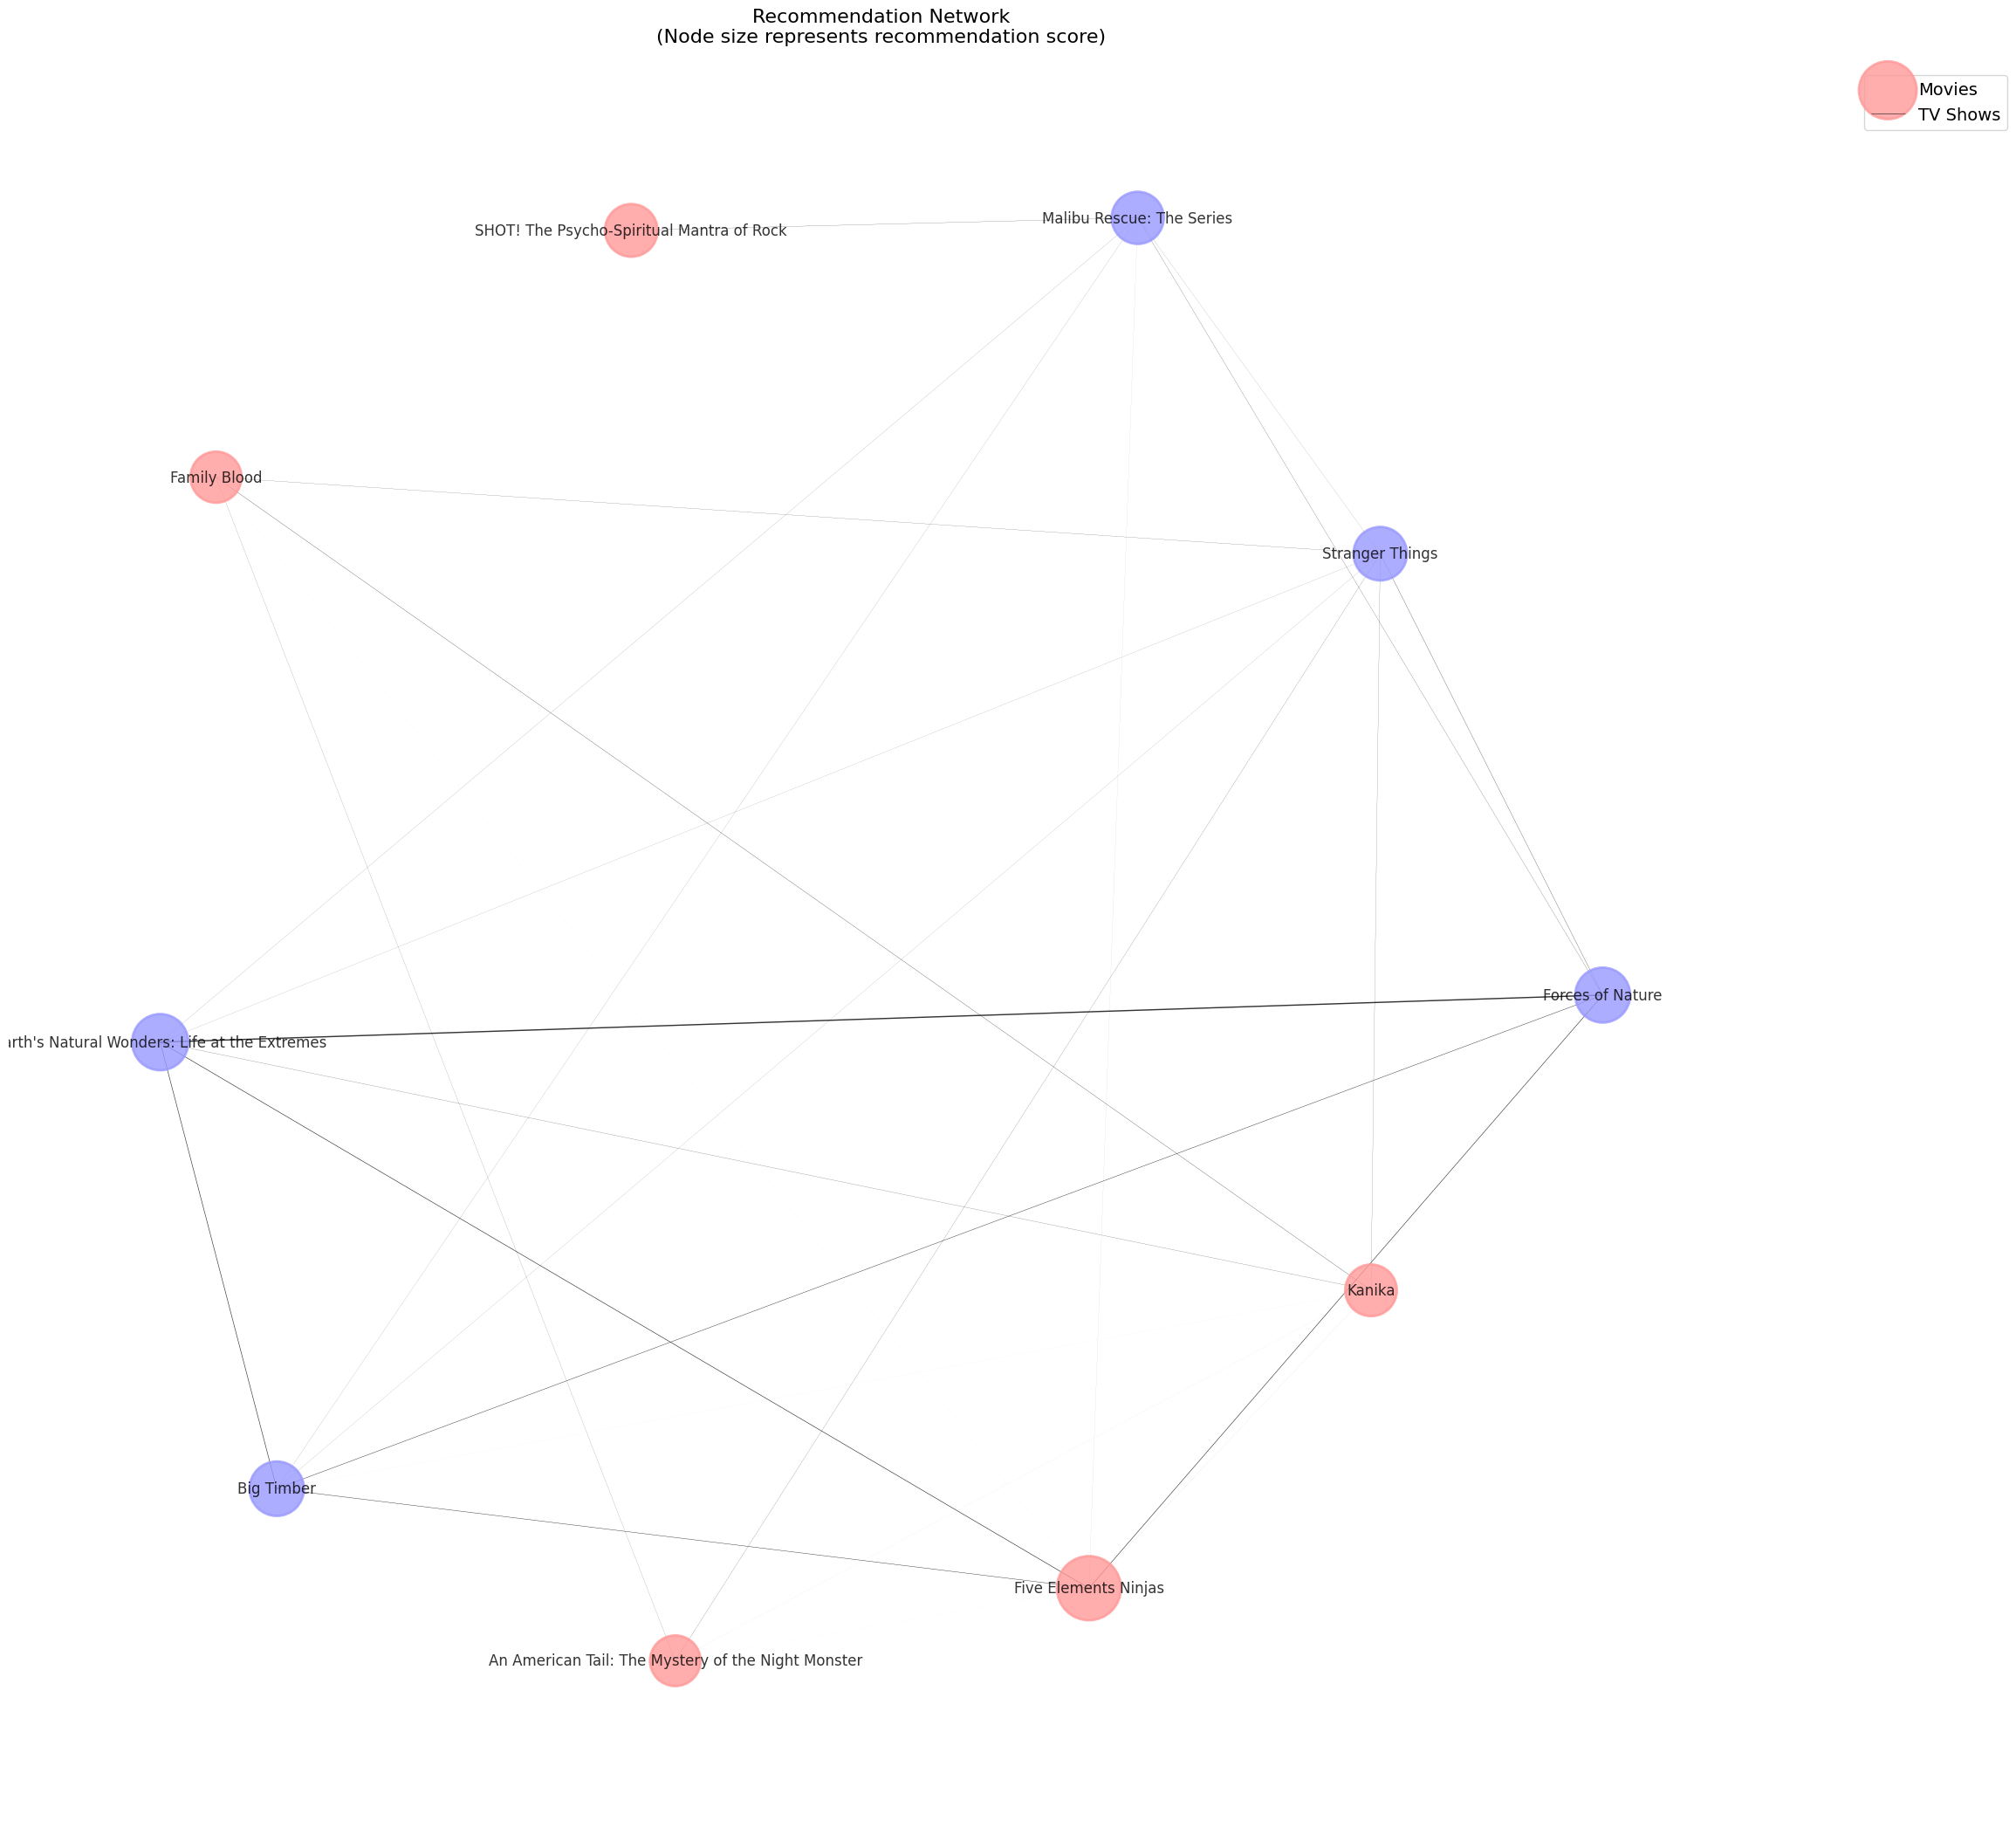


Recommendation Network Analysis:
Number of recommended items: 10
Number of connections: 45
Network density: 1.000


In [79]:
def visualize_recommendations_network(recommendations, df, tfidf_matrix):
    """
    Create a network visualization for recommended content
    """
    # Create a graph
    G = nx.Graph()
    
    # Get indices of recommended items
    rec_indices = [df[df['title'] == title].index[0] for title in recommendations['title']]
    
    # Add nodes for recommended items
    for _, row in recommendations.iterrows():
        G.add_node(row['title'], 
                  type=row['type'],
                  score=row['similarity_score'])
    
    # Add edges between recommendations based on TF-IDF similarity
    for idx1, title1 in enumerate(recommendations['title']):
        idx_in_df = df[df['title'] == title1].index[0]
        similarities = cosine_similarity(tfidf_matrix[idx_in_df:idx_in_df+1], 
                                      tfidf_matrix[rec_indices])[0]
        
        for idx2, title2 in enumerate(recommendations['title']):
            if title1 != title2:
                G.add_edge(title1, title2, weight=similarities[idx2])

    # Visualization with larger figure size
    plt.figure(figsize=(20, 20))
    
    # Node colors based on type with increased opacity
    node_colors = ['#FF9999' if G.nodes[node]['type'] == 'Movie' else '#9999FF' 
                  for node in G.nodes()]
    
    # Increased node sizes (multiplied by 4000 instead of 2000)
    node_sizes = [G.nodes[node]['score'] * 4000 for node in G.nodes()]
    
    # Create layout with more spacing
    pos = nx.spring_layout(G, k=2.0)
    
    # Draw network with thicker edges and larger font
    nx.draw(G, pos,
           node_color=node_colors,
           node_size=node_sizes,
           with_labels=True,
           font_size=12,  # Increased font size
           width=[G[u][v]['weight'] * 4 for u,v in G.edges()],  # Thicker edges
           alpha=0.8,  # Increased opacity
           linewidths=2)  # Added node border width
    
    # Add legend with larger font
    plt.legend(['Movies', 'TV Shows'],
              loc='upper right',
              bbox_to_anchor=(1.15, 1.0),
              fontsize=14)  # Increased legend font size
    
    plt.title('Recommendation Network\n(Node size represents recommendation score)',
              pad=20, fontsize=16)  # Increased title font size
    plt.tight_layout()
    
    return G

# Create visualization for the recommendations
recommendations_network = visualize_recommendations_network(recommendations, df, tfidf_matrix)
plt.show()

# Print network statistics
print("\nRecommendation Network Analysis:")
print(f"Number of recommended items: {recommendations_network.number_of_nodes()}")
print(f"Number of connections: {recommendations_network.number_of_edges()}")
print(f"Network density: {nx.density(recommendations_network):.3f}")